# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
%matplotlib inline

In [5]:
import spikeinterface

In [6]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_3248055/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [7]:
import spikeinterface.core

In [8]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [9]:
import spikeinterface.full as si

# Reading in the Timestamp Information

In [10]:
tone_label_file_ending = "tone_label_df"

In [11]:
tone_label_path = glob.glob("./proc/*{}.csv*".format(tone_label_file_ending))[0]

In [12]:
tone_label_path

'./proc/20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1_tone_label_df.csv'

In [13]:
recording_name = os.path.splitext(os.path.basename(tone_label_path))[0].strip(tone_label_file_ending)

In [14]:
recording_name

'20221214_125409_om_and_comp_6_3_top_4_base_3_vs_6_1'

In [15]:
tone_time_stamps_df = pd.read_csv(tone_label_path, index_col=0)

In [16]:
tone_time_stamps_df

,tone_time_stamp,tone_category,tone_clock_time_omission,tone_clock_time_comp
0,1408048,rewarded,60.40240,-1269.52745
1,3008051,rewarded,140.40255,-1189.52730
2,4808043,rewarded,230.40215,-1099.52770
3,6408042,omission,310.40210,-1019.52775
4,7908040,rewarded,385.40200,-944.52785
5,9908037,rewarded,485.40185,-844.52800
6,11808035,rewarded,580.40175,-749.52810
7,13608031,rewarded,670.40155,-659.52830
8,15208032,omission,750.40160,-579.52825
9,17008029,rewarded,840.40145,-489.52840


# Reading in Phy

- Which unit the spike came from

In [17]:
spike_clusters_path = glob.glob("./proc/**/phy/spike_clusters.npy", recursive=True)[0]

In [18]:
spike_clusters_path[0]

'.'

In [19]:
spike_clusters = np.load(spike_clusters_path)

In [20]:
spike_clusters[:10]

array([198, 128, 130, 136, 128, 130,  97,  95,  97,  36], dtype=int32)

- The classification of each unit

In [21]:
cluster_info_path = glob.glob("./proc/**/phy/cluster_info.tsv", recursive=True)[0]

In [22]:
cluster_group_df = pd.read_csv(cluster_info_path, sep="\t")

In [23]:
cluster_group_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,1,3293.0,22,0.0,440.0,1.462088,noise,4687,0,2.0
1,2,2630.0,18,0.0,360.0,1.751885,noise,5616,0,3.0
2,3,8613.0,18,0.0,360.0,0.375270,noise,1203,0,4.0
3,4,2303.5,18,0.0,360.0,0.511590,noise,1640,0,5.0
4,7,4248.0,18,0.0,360.0,0.301963,noise,968,0,8.0
...,...,...,...,...,...,...,...,...,...,...
127,311,223.5,30,0.0,600.0,0.078298,noise,251,0,88.0
128,312,398.0,11,0.0,220.0,0.675362,good,2165,0,30.0
129,313,398.0,11,0.0,220.0,0.025891,mua,83,0,30.0
130,316,815.0,22,0.0,440.0,0.294788,good,945,0,60.0


- Filtering for the good units

In [24]:
good_unit_cluster_info_df = cluster_group_df[cluster_group_df["group"] == "good"]

In [25]:
good_unit_cluster_info_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
10,20,662.0,6,0.0,120.0,4.142946,good,13281,0,21.0
66,96,585.0,3,0.0,60.0,4.692281,good,15042,0,14.0
69,99,466.0,3,0.0,60.0,0.361233,good,1158,0,13.0
71,101,443.0,4,0.0,80.0,1.468015,good,4706,0,16.0
72,103,443.0,4,0.0,80.0,1.165740,good,3737,0,16.0
84,124,330.0,4,0.0,80.0,3.268251,good,10477,0,18.0
92,142,360.0,12,0.0,240.0,0.543097,good,1741,0,32.0
110,195,591.0,7,0.0,140.0,0.770193,good,2469,0,24.0
120,302,307.0,21,0.0,420.0,0.459495,good,1473,0,54.0
122,304,292.5,21,0.0,420.0,0.528435,good,1694,0,55.0


In [26]:
good_unit_unique_ids = good_unit_cluster_info_df["cluster_id"].values

In [27]:
good_unit_unique_ids

array([ 20,  96,  99, 101, 103, 124, 142, 195, 302, 304, 310, 312, 316])

- The times that all the spikes happened

In [28]:
spike_time_path = glob.glob("./proc/**/phy/spike_times.npy", recursive=True)[0]

In [29]:
spike_times = np.load(spike_time_path)

In [30]:
spike_times[:10]

array([[   5],
       [ 155],
       [ 206],
       [ 430],
       [ 476],
       [ 764],
       [ 853],
       [1004],
       [1037],
       [1070]])

- Getting a list of the IDs that were good from the list of unit ids for all the firings

In [31]:
good_unit_mask = np.isin(spike_clusters, good_unit_unique_ids)

In [32]:
good_unit_all_ids = spike_clusters[good_unit_mask]

In [33]:
good_unit_all_ids.shape

(60760,)

In [34]:
good_unit_all_ids[:10]

array([103, 101,  20, 124, 124,  20,  20, 103, 124,  20], dtype=int32)

- Getting the time that the good units fired

In [35]:
good_unit_times = spike_times[good_unit_mask].T[0]

In [36]:
good_unit_times.shape

(60760,)

In [37]:
good_unit_times[:10]

array([ 1219,  1351,  3123, 15095, 15520, 16716, 20455, 22670, 24196,
       25987])

In [38]:
good_unit_times[-10:]

array([64108252, 64109999, 64110237, 64110517, 64111013, 64111446,
       64111926, 64112009, 64112103, 64113123])

- spike_times are indexed based on the start of the recording, not the start of the streaming
    - Last spike ends right before the end of the recording time

In [39]:
spike_times

array([[       5],
       [     155],
       [     206],
       ...,
       [64113574],
       [64113757],
       [64113795]])

In [40]:
spike_times[-1]/20000

array([3205.68975])

## Syncing the unit times with the ECU times

In [41]:
tone_time_stamps = tone_time_stamps_df["tone_time_stamp"].values

In [42]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

## Seeing which tone time each unit time is closest to

- We will divide all the time up into bins of before and after each tone. Then we will see which time bin the neuron firing falls into.
    - So everything in the 0 bin would be before the first time bin. The 1 bin would be everything in between the first and second time bin. The last would be everything after last time bin.

In [43]:
good_unit_bins = np.digitize(good_unit_times, tone_time_stamps_df["tone_time_stamp"], right=True)

In [44]:
good_unit_bins.shape

(60760,)

In [45]:
good_unit_bins[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
good_unit_bins[-10:]

array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33])

- Seeing if the firing time is within a 10 second interval before or 10 second after any tone

In [47]:
from collections import defaultdict

In [48]:
good_unit_bins.shape

(60760,)

In [49]:
good_unit_times.shape

(60760,)

In [50]:
good_unit_all_ids.shape

(60760,)

In [51]:
good_unit_times[:10]

array([ 1219,  1351,  3123, 15095, 15520, 16716, 20455, 22670, 24196,
       25987])

In [52]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

In [53]:
len(tone_time_stamps)

33

# Comparing Firing Rate between Trial types

In [54]:
tone_time_stamps_df.head()

,tone_time_stamp,tone_category,tone_clock_time_omission,tone_clock_time_comp
0,1408048,rewarded,60.40240,-1269.52745
1,3008051,rewarded,140.40255,-1189.52730
2,4808043,rewarded,230.40215,-1099.52770
3,6408042,omission,310.40210,-1019.52775
4,7908040,rewarded,385.40200,-944.52785


In [55]:
good_unit_times

array([    1219,     1351,     3123, ..., 64112009, 64112103, 64113123])

In [56]:
good_unit_all_ids

array([103, 101,  20, ...,  20, 124, 124], dtype=int32)

In [57]:
good_unit_bins

array([ 0,  0,  0, ..., 33, 33, 33])

In [58]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

In [59]:
"""
Step 1: 
- Get all the unit times that are 10 seconds before tone 
and 10 seconds after the tone(separately)

Step 2:
- Separate out for each trial

Step 3: Calculate firing rate
"""

'\nStep 1: \n- Get all the unit times that are 10 seconds before tone \nand 10 seconds after the tone(separately)\n\nStep 2:\n- Separate out for each trial\n\nStep 3: Calculate firing rate\n'

- Duration to include before and after tone

In [60]:
# time in seconds
trial_one_way_duration = 10

In [61]:
sampling_rate = 20000

- Getting the number of samples before and after to include for each tone

In [62]:
per_trial_number_of_samples = trial_one_way_duration * sampling_rate

In [63]:
per_trial_number_of_samples

200000

- Getting all the tones that fired within before or after the number of samples

In [64]:
before_or_after_column = "before_or_after"

In [65]:
# iterating through the timestamp of each good unit spike

before_and_after_interval_unit_times = defaultdict(dict)


for index, time in enumerate(good_unit_times):
    # getting the corresponding tone bin for the timestamp
    current_bin = good_unit_bins[index]
    current_neuron = good_unit_all_ids[index]   
#     print("Current Bin: {}".format(current_bin))
    
    # checking number before
    first_tone_time = tone_time_stamps[(current_bin - 1) % len(tone_time_stamps)]
    # checking number after
    second_tone_time = tone_time_stamps[(current_bin) % len(tone_time_stamps)]    
    
#     print("Time: {}, First tone time: {} Second tone time: {}".format(time, first_tone_time, second_tone_time))
    
    
    # checking if time is before first number
    if first_tone_time - per_trial_number_of_samples <= time <= first_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after first number
    elif first_tone_time < time <= first_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    
    # checking if time is before second number
    elif second_tone_time - per_trial_number_of_samples <= time <= second_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after second number
    elif second_tone_time < time <= second_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    else:
        continue


In [66]:
per_trial_number_of_samples

200000

In [67]:
before_and_after_interval_unit_df = pd.DataFrame.from_dict(before_and_after_interval_unit_times, orient="index").reset_index()
before_and_after_interval_unit_df = before_and_after_interval_unit_df.rename(columns={"index": "spike_time"})

In [68]:
before_and_after_interval_unit_df.head()

,spike_time,tone_time,before_or_after,neuron_id
0,1209407,1408048,before,20
1,1211138,1408048,before,20
2,1211217,1408048,before,20
3,1211572,1408048,before,302
4,1211818,1408048,before,20


- Getting the count of each neuron that fired during the tone interval grouped by the neuron's ID

In [69]:
before_and_after_tone_spike_count_df = before_and_after_interval_unit_df.groupby(["tone_time", before_or_after_column, "neuron_id"]).count().unstack(fill_value=0).stack().reset_index().rename(columns={"spike_time": "fired_spike_count"})

In [70]:
before_and_after_tone_spike_count_df

,tone_time,before_or_after,neuron_id,fired_spike_count
0,1408048,after,20,57
1,1408048,after,96,29
2,1408048,after,99,7
3,1408048,after,101,10
4,1408048,after,103,2
...,...,...,...,...
853,60998563,before,302,15
854,60998563,before,304,20
855,60998563,before,310,10
856,60998563,before,312,4


- Separating out the before and after to get them in the same rows for the same neuron

In [71]:
before_tone_spike_count_df = before_and_after_tone_spike_count_df[before_and_after_tone_spike_count_df[before_or_after_column] == "before"].rename(columns={"fired_spike_count": "before_fired_spike_count"}).drop(columns=[before_or_after_column])
after_tone_spike_count_df = before_and_after_tone_spike_count_df[before_and_after_tone_spike_count_df[before_or_after_column] == "after"].rename(columns={"fired_spike_count": "after_fired_spike_count"}).drop(columns=[before_or_after_column])

In [72]:
before_tone_spike_count_df.head()

,tone_time,neuron_id,before_fired_spike_count
13,1408048,20,38
14,1408048,96,12
15,1408048,99,1
16,1408048,101,11
17,1408048,103,5


In [73]:
after_tone_spike_count_df.head()

,tone_time,neuron_id,after_fired_spike_count
0,1408048,20,57
1,1408048,96,29
2,1408048,99,7
3,1408048,101,10
4,1408048,103,2


In [74]:
merged_before_after_tone_spike_count_df = pd.merge(left=before_tone_spike_count_df, right=after_tone_spike_count_df, left_on=["tone_time", "neuron_id"], right_on=["tone_time", "neuron_id"])

- Dictionary of tone time to trial type

In [75]:
tone_timestamp_to_trial_type = pd.Series(tone_time_stamps_df["tone_category"].values, index=tone_time_stamps_df["tone_time_stamp"]).to_dict()

In [76]:
tone_timestamp_to_trial_type

{1408048: 'rewarded',
 3008051: 'rewarded',
 4808043: 'rewarded',
 6408042: 'omission',
 7908040: 'rewarded',
 9908037: 'rewarded',
 11808035: 'rewarded',
 13608031: 'rewarded',
 15208032: 'omission',
 17008029: 'rewarded',
 19008027: 'rewarded',
 20808026: 'omission',
 23208023: 'rewarded',
 25008021: 'rewarded',
 27998597: 'win',
 29598593: 'loss',
 31398591: 'loss',
 32998593: 'loss',
 34498591: 'loss',
 36498588: 'loss',
 38398586: 'loss',
 40198584: 'loss',
 41798580: 'loss',
 43598581: 'loss',
 45598579: 'loss',
 47398577: 'loss',
 49798572: 'win',
 51598570: 'win',
 53298568: 'win',
 55098566: 'win',
 56998564: 'loss',
 59398564: 'win',
 60998563: 'win'}

- Adding the trial type

In [77]:
merged_before_after_tone_spike_count_df["trial_type"] = merged_before_after_tone_spike_count_df["tone_time"].map(tone_timestamp_to_trial_type)

In [78]:
merged_before_after_tone_spike_count_df

,tone_time,neuron_id,before_fired_spike_count,after_fired_spike_count,trial_type
0,1408048,20,38,57,rewarded
1,1408048,96,12,29,rewarded
2,1408048,99,1,7,rewarded
3,1408048,101,11,10,rewarded
4,1408048,103,5,2,rewarded
...,...,...,...,...,...
424,60998563,302,15,5,win
425,60998563,304,20,12,win
426,60998563,310,10,7,win
427,60998563,312,4,5,win


# Calculating Wilcoxon Rank Sum

In [79]:
import scipy.stats as stats

In [80]:
import itertools

- Example of what the Wilcoxon Rank Sum will compare between

In [81]:
random_trial = merged_before_after_tone_spike_count_df["trial_type"].unique()[0]

In [82]:
random_trial

'rewarded'

In [83]:
random_neuron = merged_before_after_tone_spike_count_df["neuron_id"].unique()[0]

In [84]:
random_neuron

20

In [85]:
merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == random_neuron) & (merged_before_after_tone_spike_count_df["trial_type"] == random_trial)]

,tone_time,neuron_id,before_fired_spike_count,after_fired_spike_count,trial_type
0,1408048,20,38,57,rewarded
13,3008051,20,60,39,rewarded
26,4808043,20,3,18,rewarded
52,7908040,20,5,6,rewarded
65,9908037,20,5,10,rewarded
78,11808035,20,4,3,rewarded
91,13608031,20,1,3,rewarded
117,17008029,20,0,2,rewarded
130,19008027,20,7,38,rewarded
156,23208023,20,5,5,rewarded


- Seeing which neuron has significant change with the Wilcoxon Rank Sum test

In [86]:
neuron_id_to_trial_type_to_wilcoxon_score = defaultdict(dict)
# Getting all the combinations of neuron ID and trial type
neuron_id_and_trial_type_combinations = list(itertools.product(merged_before_after_tone_spike_count_df["neuron_id"].unique(), merged_before_after_tone_spike_count_df["trial_type"].unique()))
for neuron_id, trial_type in neuron_id_and_trial_type_combinations:
    try:
        # Getting all the rows that match the neuron and the trial type
        current_df = merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == neuron_id) & (merged_before_after_tone_spike_count_df["trial_type"] == trial_type)]
        # Calculating the Wilcoxon Rank Sum
        neuron_id_to_trial_type_to_wilcoxon_score[neuron_id][trial_type] = stats.wilcoxon(current_df["before_fired_spike_count"], current_df["after_fired_spike_count"])
    except:
        print("Neuron: {} Trial Type: {}".format(neuron_id, trial_type))
        warnings.warn("Wilcoxon unable to run for these neuron and trial type combination")

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/bin/conda_environment/spike_interface_env_0_96_1/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/bin/conda_environment/spike_interface_env_0_96_1/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [87]:
neuron_id_to_trial_type_to_wilcoxon_score

defaultdict(dict,
            {20: {'rewarded': WilcoxonResult(statistic=15.5, pvalue=0.22067136191984682),
              'omission': WilcoxonResult(statistic=1.0, pvalue=0.5),
              'win': WilcoxonResult(statistic=9.0, pvalue=0.46875),
              'loss': WilcoxonResult(statistic=21.0, pvalue=0.17626953125)},
             96: {'rewarded': WilcoxonResult(statistic=23.0, pvalue=0.6460335914571025),
              'omission': WilcoxonResult(statistic=2.0, pvalue=0.75),
              'win': WilcoxonResult(statistic=11.0, pvalue=0.6875),
              'loss': WilcoxonResult(statistic=23.0, pvalue=0.2333984375)},
             99: {'rewarded': WilcoxonResult(statistic=25.5, pvalue=0.51953125),
              'omission': WilcoxonResult(statistic=3.0, pvalue=1.0),
              'win': WilcoxonResult(statistic=11.5, pvalue=0.8125),
              'loss': WilcoxonResult(statistic=27.5, pvalue=1.0)},
             101: {'rewarded': WilcoxonResult(statistic=22.5, pvalue=0.6096011155205022),


# Pie Chart for Losing and Omission

In [88]:
p_value_threshold = 0.1

In [89]:
neuron_to_wilcoxon_df = pd.DataFrame.from_dict(neuron_id_to_trial_type_to_wilcoxon_score, orient="index")

In [90]:
neuron_to_wilcoxon_df

,rewarded,omission,win,loss
20,"(15.5, 0.22067136191984682)","(1.0, 0.5)","(9.0, 0.46875)","(21.0, 0.17626953125)"
96,"(23.0, 0.6460335914571025)","(2.0, 0.75)","(11.0, 0.6875)","(23.0, 0.2333984375)"
99,"(25.5, 0.51953125)","(3.0, 1.0)","(11.5, 0.8125)","(27.5, 1.0)"
101,"(22.5, 0.6096011155205022)","(2.0, 0.75)","(1.5, 0.10405923452892792)","(23.5, 0.6830913983096087)"
103,"(27.0, 0.9591944787097265)","(3.0, 1.0)","(4.5, 0.3961439091520741)","(20.5, 0.2613952984713741)"
124,"(25.0, 0.7982172482487114)","(3.0, 1.0)","(2.0, 0.07473549830588248)","(37.0, 0.90966796875)"
142,"(13.0, 0.8648125041589424)","(2.5, 1.0)","(3.0, 0.11484960926328612)","(13.5, 0.9320385634920316)"
195,"(16.5, 0.1474609375)","(1.0, 0.5)","(7.5, 0.5282327768679831)","(0.0, 0.0033300139117459797)"
302,"(25.0, 0.7961204453748604)","(0.0, 0.15729920705028502)","(0.0, 0.015625)","(22.5, 0.3466882037602761)"
304,"(21.0, 0.8563114607187767)","(1.0, 0.6547208460185769)","(4.0, 0.16820413904818)","(26.0, 0.33935546875)"


- Getting the P Value from the tuple for each trial type

In [91]:
def get_first_item_for_lambda(value, default):
    try:
        return (value[1])
    except:
        return default
    return default

In [92]:
for col in neuron_to_wilcoxon_df.columns:
    neuron_to_wilcoxon_df["{}_pvalue".format(col)] = neuron_to_wilcoxon_df[col].apply(lambda x: get_first_item_for_lambda(value=x, default=np.nan))

In [93]:
neuron_to_wilcoxon_df.head()

,rewarded,omission,win,loss,rewarded_pvalue,omission_pvalue,win_pvalue,loss_pvalue
20,"(15.5, 0.22067136191984682)","(1.0, 0.5)","(9.0, 0.46875)","(21.0, 0.17626953125)",0.220671,0.50,0.468750,0.176270
96,"(23.0, 0.6460335914571025)","(2.0, 0.75)","(11.0, 0.6875)","(23.0, 0.2333984375)",0.646034,0.75,0.687500,0.233398
99,"(25.5, 0.51953125)","(3.0, 1.0)","(11.5, 0.8125)","(27.5, 1.0)",0.519531,1.00,0.812500,1.000000
101,"(22.5, 0.6096011155205022)","(2.0, 0.75)","(1.5, 0.10405923452892792)","(23.5, 0.6830913983096087)",0.609601,0.75,0.104059,0.683091
103,"(27.0, 0.9591944787097265)","(3.0, 1.0)","(4.5, 0.3961439091520741)","(20.5, 0.2613952984713741)",0.959194,1.00,0.396144,0.261395


In [94]:
neuron_to_wilcoxon_df

,rewarded,omission,win,loss,rewarded_pvalue,omission_pvalue,win_pvalue,loss_pvalue
20,"(15.5, 0.22067136191984682)","(1.0, 0.5)","(9.0, 0.46875)","(21.0, 0.17626953125)",0.220671,0.500000,0.468750,0.176270
96,"(23.0, 0.6460335914571025)","(2.0, 0.75)","(11.0, 0.6875)","(23.0, 0.2333984375)",0.646034,0.750000,0.687500,0.233398
99,"(25.5, 0.51953125)","(3.0, 1.0)","(11.5, 0.8125)","(27.5, 1.0)",0.519531,1.000000,0.812500,1.000000
101,"(22.5, 0.6096011155205022)","(2.0, 0.75)","(1.5, 0.10405923452892792)","(23.5, 0.6830913983096087)",0.609601,0.750000,0.104059,0.683091
103,"(27.0, 0.9591944787097265)","(3.0, 1.0)","(4.5, 0.3961439091520741)","(20.5, 0.2613952984713741)",0.959194,1.000000,0.396144,0.261395
124,"(25.0, 0.7982172482487114)","(3.0, 1.0)","(2.0, 0.07473549830588248)","(37.0, 0.90966796875)",0.798217,1.000000,0.074735,0.909668
142,"(13.0, 0.8648125041589424)","(2.5, 1.0)","(3.0, 0.11484960926328612)","(13.5, 0.9320385634920316)",0.864813,1.000000,0.114850,0.932039
195,"(16.5, 0.1474609375)","(1.0, 0.5)","(7.5, 0.5282327768679831)","(0.0, 0.0033300139117459797)",0.147461,0.500000,0.528233,0.003330
302,"(25.0, 0.7961204453748604)","(0.0, 0.15729920705028502)","(0.0, 0.015625)","(22.5, 0.3466882037602761)",0.796120,0.157299,0.015625,0.346688
304,"(21.0, 0.8563114607187767)","(1.0, 0.6547208460185769)","(4.0, 0.16820413904818)","(26.0, 0.33935546875)",0.856311,0.654721,0.168204,0.339355


In [95]:
neuron_to_wilcoxon_df.to_csv("./proc/{}_neuron_to_wilcoxon_df".format(recording_name))

- Seeing how many neurons reacted to winning and being rewarded

In [96]:
reward_or_win_firing_rate_difference_count = {}
for index, row in neuron_to_wilcoxon_df.iterrows():
    
    # if both
    if row["rewarded_pvalue"] <= p_value_threshold and row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["both_reward_and_win"] = reward_or_win_firing_rate_difference_count.get('both_reward_and_win', 0) + 1
    # if one
    elif row["rewarded_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["reward_only"] = reward_or_win_firing_rate_difference_count.get('reward_only', 0) + 1

    # if other
    elif row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["win_only"] = reward_or_win_firing_rate_difference_count.get('win_only', 0) + 1
reward_or_win_firing_rate_difference_count["no_response"] = len(neuron_to_wilcoxon_df) - sum(reward_or_win_firing_rate_difference_count.values())

In [97]:
reward_or_win_firing_rate_difference_count

{'win_only': 2, 'reward_only': 1, 'no_response': 10}

- Seeing how many neurons reacted to losing and omission of reward

In [98]:
omission_or_loss_firing_rate_difference_count = {}
for index, row in neuron_to_wilcoxon_df.iterrows():
    
    # if both
    if row["omission_pvalue"] <= p_value_threshold and row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["both_omission_and_loss"] = omission_or_loss_firing_rate_difference_count.get('both_omission_and_loss', 0) + 1
    # if one
    elif row["omission_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["omission_only"] = omission_or_loss_firing_rate_difference_count.get('omission_only', 0) + 1

    # if other
    elif row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["loss_only"] = omission_or_loss_firing_rate_difference_count.get('loss_only', 0) + 1
omission_or_loss_firing_rate_difference_count["no_response"] = len(neuron_to_wilcoxon_df) - sum(omission_or_loss_firing_rate_difference_count.values())

In [99]:
omission_or_loss_firing_rate_difference_count

{'loss_only': 1, 'no_response': 12}

- Creating a pie chart

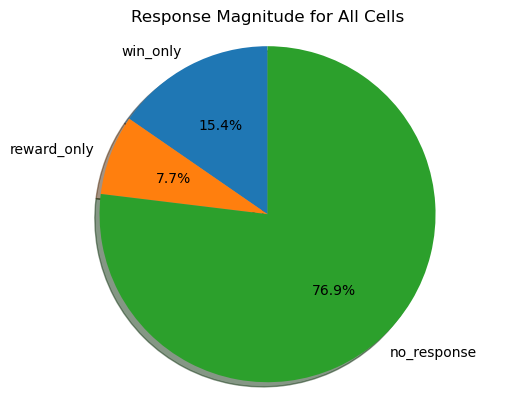

In [100]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots()
ax1.pie(reward_or_win_firing_rate_difference_count.values(), labels=reward_or_win_firing_rate_difference_count.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Response Magnitude for All Cells")
plt.show()

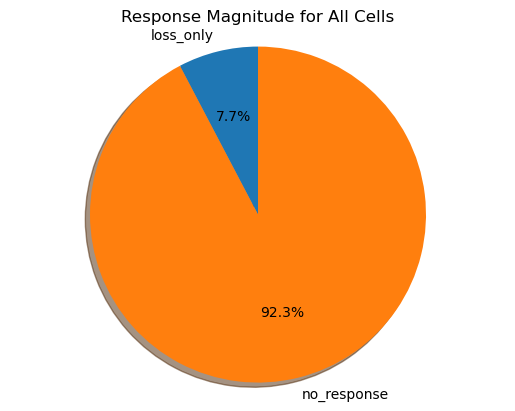

In [101]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots()
ax1.pie(omission_or_loss_firing_rate_difference_count.values(), labels=omission_or_loss_firing_rate_difference_count.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Response Magnitude for All Cells")
plt.show()

# Looking at the firing rate for each 100ms time bin

## Seeing which 100ms bin each unit time belongs to

- Creating bins for each 100ms time interval

In [102]:
# Each bin's duration in seconds
bin_duration = 0.1

In [103]:
# Seeing how many bins are in the duration
# 0.1 is for 0.1 seconds or 100 miliseconds
bins_with_100ms_range = int(trial_one_way_duration / bin_duration)

In [104]:
bins_with_100ms_range

100

In [105]:
sampling_rate

20000

- Getting all the tone time bins before and after the tone

In [106]:
tone_unit_time_to_interval = {}
# Making a list of all the bins for each tone time stamp
for time in tone_time_stamps:
    tone_unit_time_to_interval[time] = [time + num * (bin_duration * sampling_rate) for num in range(bins_with_100ms_range * -1, bins_with_100ms_range)]

- The time bins for the first tone
    - Each time should be separated by an amount of the bin_duration * the sampling rate

In [107]:
tone_time_stamps[0]

1408048

In [108]:
tone_unit_time_to_interval[tone_time_stamps[0]][:5]

[1208048.0, 1210048.0, 1212048.0, 1214048.0, 1216048.0]

In [109]:
tone_unit_time_to_interval[tone_time_stamps[0]][-5:]

[1598048.0, 1600048.0, 1602048.0, 1604048.0, 1606048.0]

In [110]:
len(tone_unit_time_to_interval[tone_time_stamps[0]])

200

- Seeing which bin the tone time fits into

In [111]:
spike_column_name = "spike_time"

In [112]:
spike_tone_time_df = pd.DataFrame.from_dict(before_and_after_interval_unit_times, orient="index").reset_index().rename(columns={"index": spike_column_name})

In [113]:
spike_tone_time_df.head()

,spike_time,tone_time,before_or_after,neuron_id
0,1209407,1408048,before,20
1,1211138,1408048,before,20
2,1211217,1408048,before,20
3,1211572,1408048,before,302
4,1211818,1408048,before,20


In [114]:
all_tone_dataframes = []
for tone_time, bins_with_100ms in tone_unit_time_to_interval.items():
    # Filtering for all the rows with the current tone
    current_tone_df = spike_tone_time_df[spike_tone_time_df["tone_time"] == tone_time].copy()
    # Getting the time that each spike occured
    spike_time = current_tone_df[spike_column_name].values
    # Seeing which bin each spike fits into
    # Subtracting the number of bins so that you can get see where the spike is relative to tone time
    current_tone_df["bin_number"] = np.digitize(spike_time, tone_unit_time_to_interval[tone_time], right=True) - bins_with_100ms_range
    # Creating a list to concatenate all dataframes
    all_tone_dataframes.append(current_tone_df)

In [115]:
binned_spike_tone_time_df = pd.concat(all_tone_dataframes)

- Calculating how much time relative to the tone

In [116]:
binned_spike_tone_time_df["bin_time"] = binned_spike_tone_time_df["bin_number"] * bin_duration

In [117]:
binned_spike_tone_time_df.head()

,spike_time,tone_time,before_or_after,neuron_id,bin_number,bin_time
0,1209407,1408048,before,20,-99,-9.9
1,1211138,1408048,before,20,-98,-9.8
2,1211217,1408048,before,20,-98,-9.8
3,1211572,1408048,before,302,-98,-9.8
4,1211818,1408048,before,20,-98,-9.8


In [118]:
binned_spike_tone_time_df.tail()

,spike_time,tone_time,before_or_after,neuron_id,bin_number,bin_time
11496,61193160,60998563,after,101,98,9.8
11497,61193667,60998563,after,312,98,9.8
11498,61195621,60998563,after,96,99,9.9
11499,61197485,60998563,after,96,100,10.0
11500,61197638,60998563,after,101,100,10.0


## Calculating Firing Rate

- Getting the count of each neuron that fired during the tone interval grouped by the neuron's ID

In [119]:
binned_spike_fire_count_df = binned_spike_tone_time_df.drop(columns=["before_or_after", "bin_number"]).groupby(["tone_time", "bin_time", "neuron_id"]).count().unstack(fill_value=0).stack().reset_index().rename(columns={"spike_time": "fired_spike_count"})

In [120]:
binned_spike_fire_count_df.head()

,tone_time,bin_time,neuron_id,fired_spike_count
0,1408048,-9.9,20,1
1,1408048,-9.9,96,0
2,1408048,-9.9,99,0
3,1408048,-9.9,101,0
4,1408048,-9.9,103,0


In [121]:
binned_spike_fire_count_df.tail()

,tone_time,bin_time,neuron_id,fired_spike_count
66204,60998563,10.0,302,0
66205,60998563,10.0,304,0
66206,60998563,10.0,310,0
66207,60998563,10.0,312,0
66208,60998563,10.0,316,0


## Categorizing Rewarded vs Omitted for Training

In [122]:
binned_spike_fire_count_df["trial_type"] = binned_spike_fire_count_df["tone_time"].map(tone_timestamp_to_trial_type)

In [123]:
binned_spike_fire_count_df.head()

,tone_time,bin_time,neuron_id,fired_spike_count,trial_type
0,1408048,-9.9,20,1,rewarded
1,1408048,-9.9,96,0,rewarded
2,1408048,-9.9,99,0,rewarded
3,1408048,-9.9,101,0,rewarded
4,1408048,-9.9,103,0,rewarded


In [124]:
binned_spike_fire_count_df.tail()

,tone_time,bin_time,neuron_id,fired_spike_count,trial_type
66204,60998563,10.0,302,0,win
66205,60998563,10.0,304,0,win
66206,60998563,10.0,310,0,win
66207,60998563,10.0,312,0,win
66208,60998563,10.0,316,0,win


## Calculate average firing rate for each neuron in each bin

- We will be averaging using the bin number, because we are curious about how the firing rate changes 10 seconds before and after at each 100ms bin(averaging across sessions)
    - And we will be averaging across trials that have the same trial type

- Neurons in rows
- Mean firing rate per bin

In [125]:
averaged_firing_rate_df = binned_spike_fire_count_df.drop(columns=["tone_time"]).groupby(['neuron_id', 'bin_time', 'trial_type']).mean().reset_index()

In [126]:
averaged_firing_rate_df

,neuron_id,bin_time,trial_type,fired_spike_count
0,20,-9.9,loss,0.818182
1,20,-9.9,omission,0.000000
2,20,-9.9,rewarded,0.400000
3,20,-9.9,win,0.571429
4,20,-9.8,loss,1.272727
...,...,...,...,...
10265,316,9.9,win,0.000000
10266,316,10.0,loss,0.000000
10267,316,10.0,omission,0.000000
10268,316,10.0,rewarded,0.000000


In [127]:
pivoted_averaged_firing_rate_df = averaged_firing_rate_df.pivot_table(values='fired_spike_count', columns=['bin_time', 'trial_type'], index=["neuron_id"])

In [128]:
pivoted_averaged_firing_rate_df.head()

bin_time       -9.9                                  -9.8                      \
trial_type      loss omission rewarded       win      loss omission  rewarded   
neuron_id                                                                       
20          0.818182      0.0      0.4  0.571429  1.272727      0.0  1.166667   
96          0.181818      0.0      0.8  0.714286  0.000000      1.5  0.333333   
99          0.090909      0.0      0.0  0.000000  0.000000      0.0  0.000000   
101         0.181818      2.0      0.0  0.000000  0.181818      0.0  0.000000   
103         0.272727      1.0      0.2  0.000000  0.181818      0.5  0.000000   

bin_time                 -9.7            ...     9.8             9.9   \
trial_type       win      loss omission  ... rewarded   win      loss   
neuron_id                                ...                            
20          0.285714  0.363636      0.0  ...     0.25  0.00  0.500000   
96          0.857143  0.363636      1.0  ...     0.50  1.00  0.333333   
99          0.000000  0.000000      0.0  ...     0.00  0.00  0.083333   
101         0.000000  0.454545      0.0  ...     0.00  0.25  0.333333   
103         0.000000  0.090909      0.0  ...     0.00  0.00  0.250000   

bin_time                                10.0                         
trial_type omission rewarded   win      loss omission rewarded  win  
neuron_id                                                            
20              0.0      0.0  0.00  0.454545      0.0     0.25  0.2  
96              0.0      0.6  0.25  0.181818      0.5     0.75  0.8  
99              0.0      0.0  0.00  0.090909      0.0     0.00  0.2  
101             0.0      0.4  0.00  0.545455      0.0     0.75  0.2  
103             0.0      0.0  0.00  0.181818      0.5     0.00  0.2  

[5 rows x 790 columns]

- Removing all the columns that don't have firing rate info
    - AKA the index and the tone time

In [129]:
resetted_averaged_firing_rate_array = pivoted_averaged_firing_rate_df.values

In [130]:
resetted_averaged_firing_rate_array[:5]

array([[0.81818182, 0.        , 0.4       , ..., 0.        , 0.25      ,
        0.2       ],
       [0.18181818, 0.        , 0.8       , ..., 0.5       , 0.75      ,
        0.8       ],
       [0.09090909, 0.        , 0.        , ..., 0.        , 0.        ,
        0.2       ],
       [0.18181818, 2.        , 0.        , ..., 0.        , 0.75      ,
        0.2       ],
       [0.27272727, 1.        , 0.2       , ..., 0.5       , 0.        ,
        0.2       ]])

# PCA with Neuron Rows

## Standarizing the Data

In [131]:
from sklearn.preprocessing import StandardScaler

In [132]:
# Separating out the features
x = resetted_averaged_firing_rate_array#.loc[:].values# Separating out the target
resetted_averaged_firing_rate_array = StandardScaler().fit_transform(x)

## Calculating the PCA

In [133]:
from sklearn.decomposition import PCA


- Getting the PC Coeffecients

In [134]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(resetted_averaged_firing_rate_array)
principal_df = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [135]:
principal_df.head()

,principal component 1,principal component 2
0,22.846043,30.919615
1,49.739506,-24.020544
2,-14.131593,-2.053011
3,0.506193,1.051815
4,-2.905759,-3.590951


In [136]:
principal_df["principal component 1"]

0     22.846043
1     49.739506
2    -14.131593
3      0.506193
4     -2.905759
5     27.124623
6    -11.958200
7     -9.919051
8    -12.951685
9    -11.594753
10   -10.404934
11   -10.599725
12   -15.750665
Name: principal component 1, dtype: float64

In [137]:
pc1_product = pivoted_averaged_firing_rate_df.reset_index(drop=True).multiply(principal_df["principal component 1"], axis="index")

In [138]:
pc1_product

bin_time        -9.9                                        -9.8              \
trial_type       loss   omission   rewarded        win       loss   omission   
0           18.692217   0.000000   9.138417  13.054881  29.076781   0.000000   
1            9.043547   0.000000  39.791605  35.528219   0.000000  74.609259   
2           -1.284690  -0.000000  -0.000000  -0.000000  -0.000000  -0.000000   
3            0.092035   1.012385   0.000000   0.000000   0.092035   0.000000   
4           -0.792480  -2.905759  -0.581152  -0.000000  -0.528320  -1.452879   
5            9.863499  27.124623   0.000000   7.749892  12.329374  13.562312   
6           -1.087109  -0.000000  -0.000000  -1.708314  -3.261327  -0.000000   
7           -4.508659  -0.000000  -0.000000  -0.000000  -5.410391  -0.000000   
8           -0.000000  -0.000000  -2.590337  -0.000000  -1.177426  -0.000000   
9           -0.000000 -11.594753  -0.000000  -1.656393  -0.000000  -0.000000   
10          -0.000000  -0.000000  -0.000000  -1.486419  -0.945903  -0.000000   
11          -0.963611  -0.000000  -4.239890  -0.000000  -0.000000  -0.000000   
12          -0.000000  -0.000000  -0.000000  -4.500190  -1.431879  -0.000000   

bin_time                              -9.7              ...       9.8   \
trial_type   rewarded        win       loss   omission  ...   rewarded   
0           26.653716   6.527441   8.307652   0.000000  ...   5.711511   
1           16.579835  42.633862  18.087093  49.739506  ...  24.869753   
2           -0.000000  -0.000000  -0.000000  -0.000000  ...  -0.000000   
3            0.000000   0.000000   0.230088   0.000000  ...   0.000000   
4           -0.000000  -0.000000  -0.264160  -0.000000  ...  -0.000000   
5            0.000000  15.499785   9.863499   0.000000  ...  13.562312   
6           -0.000000  -0.000000  -3.261327  -0.000000  ...  -2.989550   
7           -0.000000  -1.417007  -4.508659  -0.000000  ...  -0.000000   
8           -2.158614  -1.850241  -1.177426  -0.000000  ...  -0.000000   
9           -0.000000  -3.312787  -0.000000  -0.000000  ...  -2.898688   
10          -0.000000  -1.486419  -2.837709  -0.000000  ...  -0.000000   
11          -3.533242  -0.000000  -0.000000  -0.000000  ...  -0.000000   
12          -2.625111  -0.000000  -1.431879  -0.000000  ...  -0.000000   

bin_time                    9.9                                        10.0  \
trial_type        win       loss  omission   rewarded        win       loss   
0            0.000000  11.423021  0.000000   0.000000   0.000000  10.384565   
1           49.739506  16.579835  0.000000  29.843704  12.434877   9.043547   
2           -0.000000  -1.177633 -0.000000  -0.000000  -0.000000  -1.284690   
3            0.126548   0.168731  0.000000   0.202477   0.000000   0.276105   
4           -0.000000  -0.726440 -0.000000  -0.000000  -0.000000  -0.528320   
5            6.781156  15.822697  0.000000  10.849849  20.343467  12.329374   
6           -2.989550  -1.993033 -0.000000  -0.000000  -0.000000  -2.174218   
7           -0.000000  -1.653175 -9.919051  -0.000000  -0.000000  -2.705196   
8           -0.000000  -0.000000 -0.000000  -0.000000  -0.000000  -0.000000   
9           -0.000000  -0.966229 -0.000000  -0.000000  -0.000000  -3.162205   
10          -0.000000  -1.734156 -0.000000  -0.000000  -0.000000  -0.000000   
11          -2.649931  -1.766621 -0.000000  -0.000000  -2.649931  -0.963611   
12          -0.000000  -2.625111 -0.000000  -0.000000  -0.000000  -0.000000   

bin_time                                     
trial_type   omission   rewarded        win  
0            0.000000   5.711511   4.569209  
1           24.869753  37.304630  39.791605  
2           -0.000000  -0.000000  -2.826319  
3            0.000000   0.379644   0.101239  
4           -1.452879  -0.000000  -0.581152  
5           27.124623   0.000000   5.424925  
6           -0.000000  -0.000000  -0.000000  
7           -0.000000  -2.479763  -0.000000  
8           -0.000000  -0.000000  -0.00000

In [139]:
pc1_product.mean()

bin_time  trial_type
-9.9      loss          2.234981
          omission      1.048961
          rewarded      3.193742
          win           3.613975
-9.8      loss          2.210996
                          ...   
 9.9      win           2.317570
 10.0     loss          1.631950
          omission      3.441855
          rewarded      2.743451
          win           3.575347
Length: 790, dtype: float64

In [140]:
pc2_product = pivoted_averaged_firing_rate_df.reset_index(drop=True).multiply(principal_df["principal component 2"], axis="index")

In [141]:
pc2_product

bin_time        -9.9                                        -9.8              \
trial_type       loss   omission   rewarded        win       loss   omission   
0           25.297867   0.000000  12.367846  17.668352  39.352238   0.000000   
1           -4.367372  -0.000000 -19.216435 -17.157531  -0.000000 -36.030815   
2           -0.186637  -0.000000  -0.000000  -0.000000  -0.000000  -0.000000   
3            0.191239   2.103631   0.000000   0.000000   0.191239   0.000000   
4           -0.979350  -3.590951  -0.718190  -0.000000  -0.652900  -1.795475   
5            3.913237  10.761403   0.000000   3.074687   4.891547   5.380701   
6           -0.213938  -0.000000  -0.000000  -0.336188  -0.641814  -0.000000   
7           -0.488479  -0.000000  -0.000000  -0.000000  -0.586175  -0.000000   
8           -0.000000  -0.000000  -0.459501  -0.000000  -0.208864  -0.000000   
9           -0.000000  -3.093842  -0.000000  -0.441977  -0.000000  -0.000000   
10          -0.000000  -0.000000  -0.000000  -0.326339  -0.207671  -0.000000   
11          -0.046628  -0.000000  -0.205165  -0.000000  -0.000000  -0.000000   
12          -0.000000  -0.000000  -0.000000  -0.414777  -0.131975  -0.000000   

bin_time                              -9.7              ...       9.8   \
trial_type   rewarded        win       loss   omission  ...   rewarded   
0           36.072885   8.834176  11.243496   0.000000  ...   7.729904   
1           -8.006848 -20.589037  -8.734743 -24.020544  ... -12.010272   
2           -0.000000  -0.000000  -0.000000  -0.000000  ...  -0.000000   
3            0.000000   0.000000   0.478098   0.000000  ...   0.000000   
4           -0.000000  -0.000000  -0.326450  -0.000000  ...  -0.000000   
5            0.000000   6.149373   3.913237   0.000000  ...   5.380701   
6           -0.000000  -0.000000  -0.641814  -0.000000  ...  -0.588329   
7           -0.000000  -0.153522  -0.488479  -0.000000  ...  -0.000000   
8           -0.382918  -0.328215  -0.208864  -0.000000  ...  -0.000000   
9           -0.000000  -0.883955  -0.000000  -0.000000  ...  -0.773461   
10          -0.000000  -0.326339  -0.623012  -0.000000  ...  -0.000000   
11          -0.170971  -0.000000  -0.000000  -0.000000  ...  -0.000000   
12          -0.241953  -0.000000  -0.131975  -0.000000  ...  -0.000000   

bin_time                    9.9                                       10.0  \
trial_type        win       loss  omission   rewarded       win       loss   
0            0.000000  15.459808  0.000000   0.000000  0.000000  14.054371   
1          -24.020544  -8.006848 -0.000000 -14.412326 -6.005136  -4.367372   
2           -0.000000  -0.171084 -0.000000  -0.000000 -0.000000  -0.186637   
3            0.262954   0.350605  0.000000   0.420726  0.000000   0.573717   
4           -0.000000  -0.897738 -0.000000  -0.000000 -0.000000  -0.652900   
5            2.690351   6.277485  0.000000   4.304561  8.071052   4.891547   
6           -0.588329  -0.392220 -0.000000  -0.000000 -0.000000  -0.427876   
7           -0.000000  -0.179109 -1.074654  -0.000000 -0.000000  -0.293088   
8           -0.000000  -0.000000 -0.000000  -0.000000 -0.000000  -0.000000   
9           -0.000000  -0.257820 -0.000000  -0.000000 -0.000000  -0.843775   
10          -0.000000  -0.380729 -0.000000  -0.000000 -0.000000  -0.000000   
11          -0.128228  -0.085485 -0.000000  -0.000000 -0.128228  -0.046628   
12          -0.000000  -0.241953 -0.000000  -0.000000 -0.000000  -0.000000   

bin_time                                     
trial_type   omission   rewarded        win  
0            0.000000   7.729904   6.183923  
1          -12.010272 -18.015408 -19.216435  
2           -0.000000  -0.000000  -0.410602  
3            0.000000   0.788861   0.210363  
4           -1.795475  -0.000000  -0.718190  
5           10.761403   0.000000   2.152281  
6           -0.000000  -0.000000  -0.000000  
7           -0.000000  -0.268664  -0.000000  
8           -0.000000  -0.000000  -0.000000  
9          

In [142]:
pc2_product.mean()

bin_time  trial_type
-9.9      loss          1.778457
          omission      0.475403
          rewarded     -0.633188
          win           0.158940
-9.8      loss          3.231202
                          ...   
 9.9      win           0.149053
 10.0     loss          0.977028
          omission     -0.353174
          rewarded     -0.804971
          win          -0.907589
Length: 790, dtype: float64

In [143]:
pc_product = pd.concat([pc1_product.mean(), pc2_product.mean()], axis=1)#.reset_index()

In [144]:
pc_product.head()

0         1
bin_time trial_type                    
-9.9     loss        2.234981  1.778457
         omission    1.048961  0.475403
         rewarded    3.193742 -0.633188
         win         3.613975  0.158940
-9.8     loss        2.210996  3.231202

In [145]:
pc_product = pc_product.reset_index()

In [146]:
pc_product.head()

,bin_time,trial_type,0,1
0,-9.9,loss,2.234981,1.778457
1,-9.9,omission,1.048961,0.475403
2,-9.9,rewarded,3.193742,-0.633188
3,-9.9,win,3.613975,0.158940
4,-9.8,loss,2.210996,3.231202


In [147]:
def get_before_during_after(x):
    if -10 <= x < -5:
        return "-10s to 5s"
    elif -5 <= x < 0:
        return "-5s to 0s"
    elif 0 <= x < 5:
        return "0s to 5s"
    elif 5 <= x <= 10:
        return "5s to 10s"
    else:
        return np.nan

In [148]:
pc_product["before_during_after"] = pc_product["bin_time"].apply(lambda x: get_before_during_after(x))

In [149]:
pc_product.head()

,bin_time,trial_type,0,1,before_during_after
0,-9.9,loss,2.234981,1.778457,-10s to 5s
1,-9.9,omission,1.048961,0.475403,-10s to 5s
2,-9.9,rewarded,3.193742,-0.633188,-10s to 5s
3,-9.9,win,3.613975,0.158940,-10s to 5s
4,-9.8,loss,2.210996,3.231202,-10s to 5s


In [150]:
pc_product["outcome_and_when"] = pc_product.apply(lambda x: x["before_during_after"] + " " + x["trial_type"], axis=1)

In [151]:
pc_product.head()

,bin_time,trial_type,0,1,before_during_after,outcome_and_when
0,-9.9,loss,2.234981,1.778457,-10s to 5s,-10s to 5s loss
1,-9.9,omission,1.048961,0.475403,-10s to 5s,-10s to 5s omission
2,-9.9,rewarded,3.193742,-0.633188,-10s to 5s,-10s to 5s rewarded
3,-9.9,win,3.613975,0.158940,-10s to 5s,-10s to 5s win
4,-9.8,loss,2.210996,3.231202,-10s to 5s,-10s to 5s loss


- Getting only rows from -5 to 5 seconds

In [152]:
pc_product = pc_product[pc_product["bin_time"] >= -5]

In [153]:
omission_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "omission" in name]
rewarded_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "rewarded" in name]
win_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "win" in name]
loss_categories = [name for name in sorted(pc_product["outcome_and_when"].unique()) if "loss" in name]


In [154]:
pc_product

,bin_time,trial_type,0,1,before_during_after,outcome_and_when
192,-5.0,loss,2.887866,2.565904,-5s to 0s,-5s to 0s loss
193,-5.0,omission,0.452822,0.227875,-5s to 0s,-5s to 0s omission
194,-5.0,rewarded,2.118609,0.772816,-5s to 0s,-5s to 0s rewarded
195,-5.0,win,4.468814,-1.008969,-5s to 0s,-5s to 0s win
196,-4.9,loss,3.578109,2.156433,-5s to 0s,-5s to 0s loss
...,...,...,...,...,...,...
785,9.9,win,2.317570,0.149053,5s to 10s,5s to 10s win
786,10.0,loss,1.631950,0.977028,5s to 10s,5s to 10s loss
787,10.0,omission,3.441855,-0.353174,5s to 10s,5s to 10s omission
788,10.0,rewarded,2.743451,-0.804971,5s to 10s,5s to 10s rewarded


In [155]:
omission_pc = pc_product[pc_product["trial_type"] == "omission"]

In [156]:
omission_pc

,bin_time,trial_type,0,1,before_during_after,outcome_and_when
193,-5.0,omission,0.452822,0.227875,-5s to 0s,-5s to 0s omission
197,-4.9,omission,0.038938,0.080909,-5s to 0s,-5s to 0s omission
201,-4.8,omission,7.652232,-3.695468,-5s to 0s,-5s to 0s omission
205,-4.7,omission,-0.511950,-0.225974,-5s to 0s,-5s to 0s omission
209,-4.6,omission,3.826116,-1.847734,-5s to 0s,-5s to 0s omission
...,...,...,...,...,...,...
771,9.6,omission,-2.755571,-0.436128,5s to 10s,5s to 10s omission
775,9.7,omission,-0.223520,-0.276227,5s to 10s,5s to 10s omission
779,9.8,omission,3.826116,-1.847734,5s to 10s,5s to 10s omission
783,9.9,omission,-0.763004,-0.082666,5s to 10s,5s to 10s omission


In [157]:
averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()

/tmp/ipykernel_3248055/866166829.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_omission_pc = omission_pc.groupby(np.arange(len(omission_pc))//3).mean().reset_index()


In [158]:
averaged_omission_pc

,index,bin_time,0,1
0,0,-4.900000,2.714664,-1.128895
1,1,-4.600000,2.380094,-1.307147
2,2,-4.133333,1.124213,0.493293
3,3,-3.800000,4.663212,-0.350083
4,4,-3.500000,2.575292,0.548377
5,5,-3.200000,2.444836,-0.330272
6,6,-2.900000,2.846430,0.030108
7,7,-2.600000,2.366727,0.113780
8,8,-2.300000,1.929775,-0.725391
9,9,-2.000000,2.880999,-1.044934


In [159]:
rewarded_pc = pc_product[pc_product["trial_type"] == "rewarded"]

In [160]:
rewarded_pc

,bin_time,trial_type,0,1,before_during_after,outcome_and_when
194,-5.0,rewarded,2.118609,0.772816,-5s to 0s,-5s to 0s rewarded
198,-4.9,rewarded,4.743123,0.155149,-5s to 0s,-5s to 0s rewarded
202,-4.8,rewarded,1.968217,0.588859,-5s to 0s,-5s to 0s rewarded
206,-4.7,rewarded,2.802792,-0.957742,-5s to 0s,-5s to 0s rewarded
210,-4.6,rewarded,2.513302,-0.510973,-5s to 0s,-5s to 0s rewarded
...,...,...,...,...,...,...
772,9.6,rewarded,2.345006,-0.624897,5s to 10s,5s to 10s rewarded
776,9.7,rewarded,2.663358,-0.501962,5s to 10s,5s to 10s rewarded
780,9.8,rewarded,2.942718,-0.020112,5s to 10s,5s to 10s rewarded
784,9.9,rewarded,3.145848,-0.745157,5s to 10s,5s to 10s rewarded


In [161]:
averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(rewarded_pc))//3).mean().reset_index()

/tmp/ipykernel_3248055/1512505606.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  averaged_rewarded_pc = rewarded_pc.groupby(np.arange(len(rewarded_pc))//3).mean().reset_index()


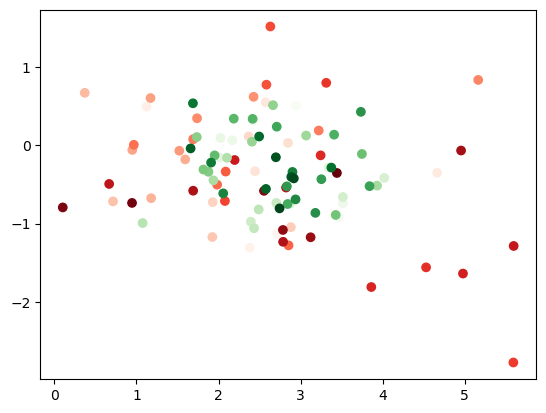

In [162]:
plt.scatter(averaged_omission_pc[0], averaged_omission_pc[1], c=averaged_omission_pc["index"], cmap='Reds')
plt.scatter(averaged_rewarded_pc[0], averaged_rewarded_pc[1], c=averaged_rewarded_pc["index"], cmap='Greens')

plt.show()

In [163]:
all_categories = sorted(pc_product["outcome_and_when"].unique())

In [164]:
all_categories = [category for category in all_categories if not "-10" in category]

In [165]:
all_categories

['-5s to 0s loss',
 '-5s to 0s omission',
 '-5s to 0s rewarded',
 '-5s to 0s win',
 '0s to 5s loss',
 '0s to 5s omission',
 '0s to 5s rewarded',
 '0s to 5s win',
 '5s to 10s loss',
 '5s to 10s omission',
 '5s to 10s rewarded',
 '5s to 10s win']

win: blue
loss: yellow
rewarded: green
omission: red

In [166]:
all_colors = ["gold", "pink", "lightgreen", "lightblue", "orange", "red", "green", "cyan", "darkorange", "darkred", "darkgreen", "darkcyan"]


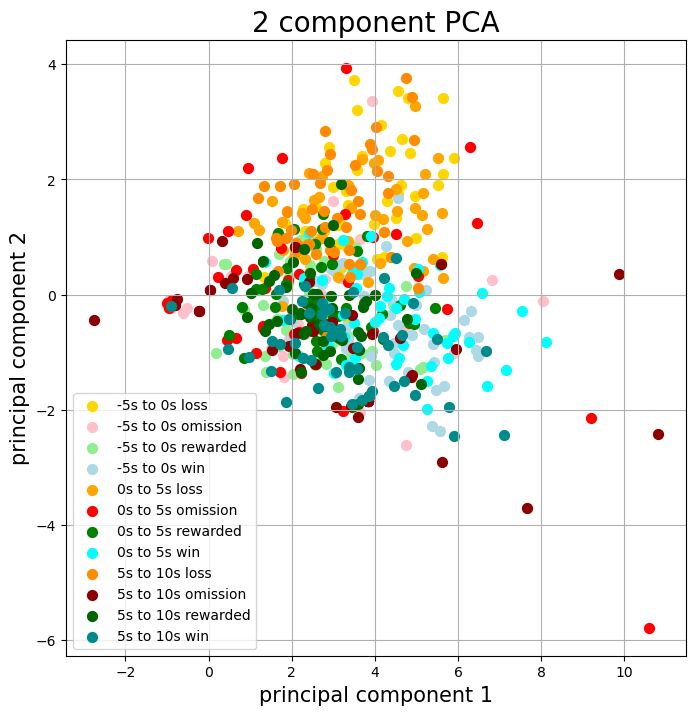

In [167]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(all_categories, all_colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(all_categories)
ax.grid()

## Looking at each plot individually across time

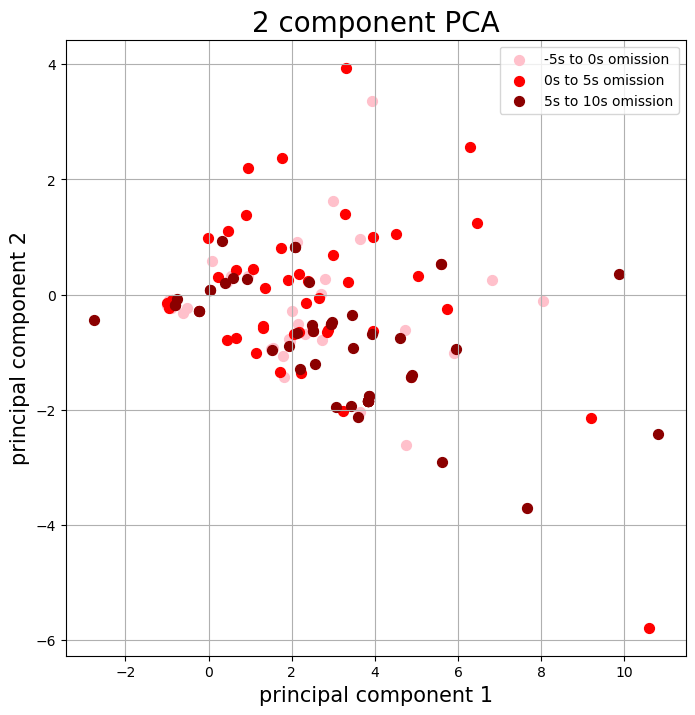

In [168]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = omission_categories
colors = ["pink", "red", "darkred"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

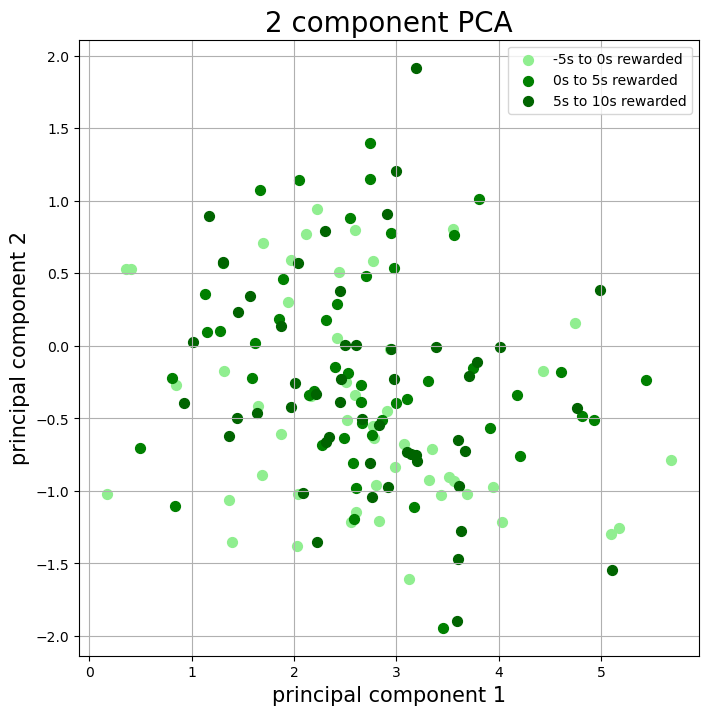

In [169]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = rewarded_categories
colors = ["lightgreen", "green", "darkgreen"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

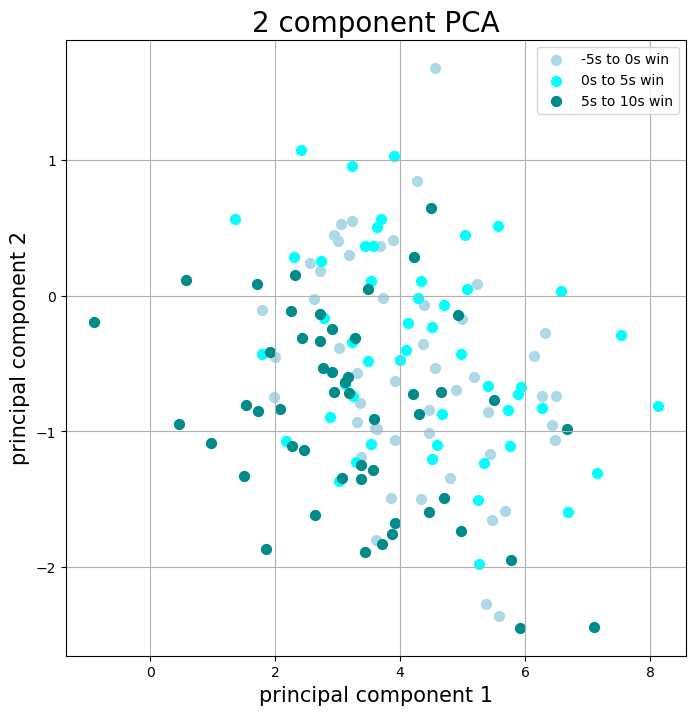

In [170]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = win_categories
colors = ["lightblue", "cyan", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

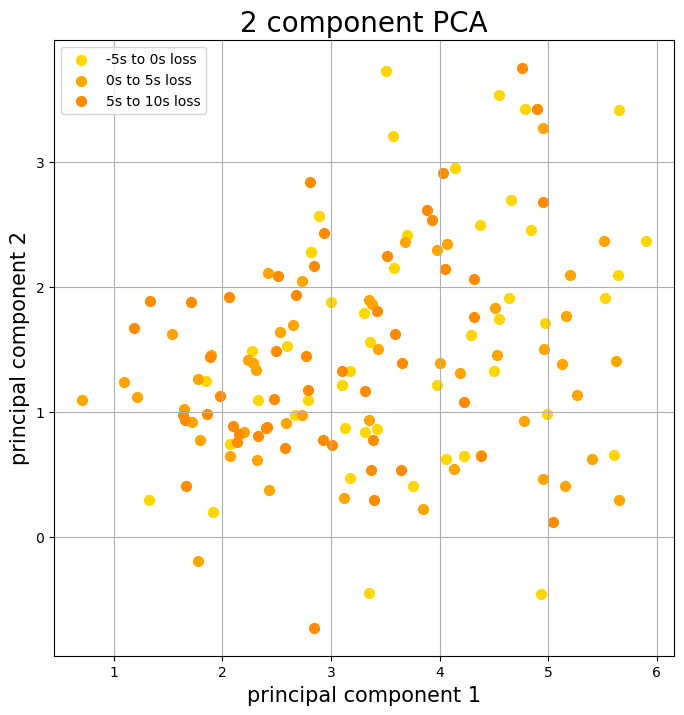

In [171]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('principal component 1', fontsize = 15)
ax.set_ylabel('principal component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = loss_categories
colors = ["gold", "orange", "darkorange"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

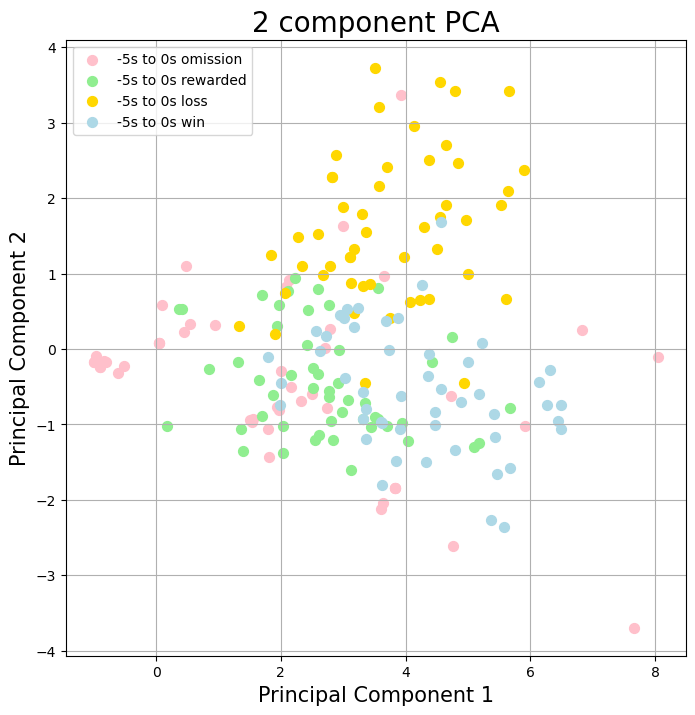

In [172]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['-5s to 0s omission', '-5s to 0s rewarded', '-5s to 0s loss', '-5s to 0s win']
colors = ["pink", "lightgreen", "gold", "lightblue"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

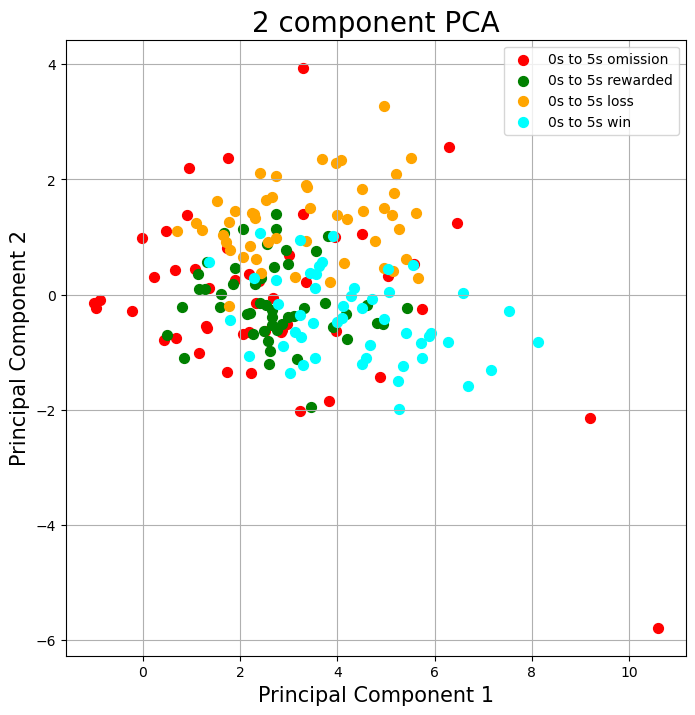

In [173]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['0s to 5s omission', '0s to 5s rewarded', '0s to 5s loss', '0s to 5s win']
colors = ["red", "green", "orange", "cyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

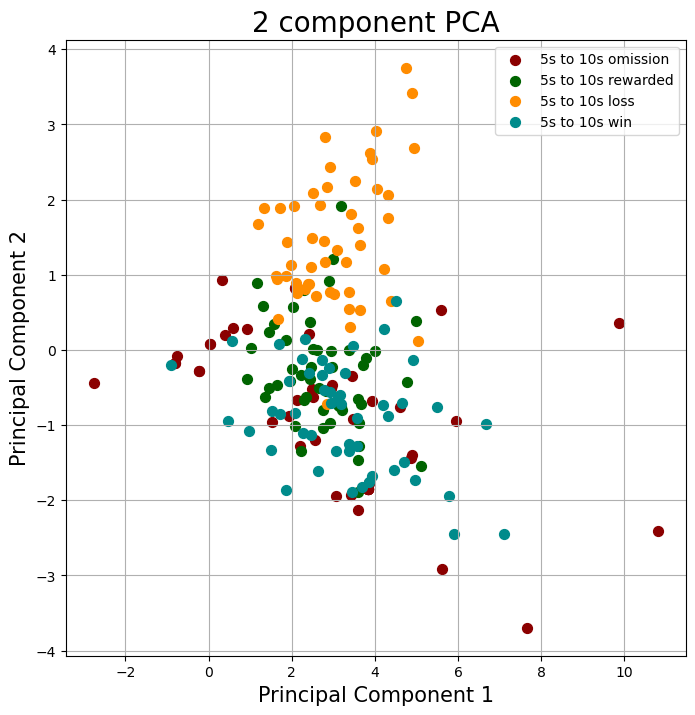

In [174]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['5s to 10s omission', '5s to 10s rewarded', '5s to 10s loss', '5s to 10s win']
colors = ["darkred", "darkgreen", "darkorange", "darkcyan"]
for target, color in zip(targets,colors):
    indicesToKeep = pc_product['outcome_and_when'] == target
    ax.scatter(pc_product.loc[indicesToKeep, 0]
               , pc_product.loc[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()